In [104]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import ast

class GTZANSegmentsDataset(Dataset): 
    def __init__(self, df, labels):
        self.df = df
        self.labels = labels
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df[idx]
        
        # Convert the string to an actual Python object (list or list of lists)
        parsed_row = ast.literal_eval(row)
        
        # Convert to a NumPy array or directly to torch.Tensor
        X_np = np.array(parsed_row, dtype=np.float32)  
        segments_tensor = torch.tensor(X_np, dtype=torch.float)
    
        labelMap = {
            "blues": 0,
            "classical": 1,
            "country": 2,
            "disco": 3,
            "hiphop": 4,
            "jazz": 5,
            "metal": 6,
            "pop": 7,
            "reggae": 8,
            "rock": 9
        }
        
        y_df = labelMap[self.labels[idx]]
        label_tensor = torch.tensor(y_df)
        
        return {
            "segments": segments_tensor,
            "label": label_tensor
        }

In [116]:
df = pd.read_csv("../data/files/audio_classification_deep.csv")

X = df['features'].to_numpy()
y = df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1122)

train_dataset = GTZANSegmentsDataset(X_train, y_train)
test_dataset  = GTZANSegmentsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

In [117]:
class AudioTransformerClassifier(nn.Module):
    def __init__(self, feature_dim, model_dim, num_heads, num_layers, num_classes, max_seq_len=10):
        """
        A simple Transformer-based classifier:
          - Each time step = 1 segment
          - Each segment has feature_dim features
          - Map segments to embeddings of size model_dim
          - Learn positional embeddings up to max_seq_len
          - TransformerEncoder of `num_layers` layers
          - Classification head (pooling + linear)
        """
        super().__init__()
        self.feature_dim = feature_dim
        self.model_dim = model_dim
        self.max_seq_len = max_seq_len

        # 1. Convert segment features -> model_dim
        self.input_proj = nn.Linear(feature_dim, model_dim)

        # 2. Positional embeddings
        self.pos_embedding = nn.Embedding(max_seq_len, model_dim)

        # 3. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 4. Classification head
        self.classifier = nn.Sequential(
            nn.Linear(model_dim, model_dim),
            nn.ReLU(),
            nn.Linear(model_dim, num_classes)
        )

    def forward(self, x):
        """
        x shape: (batch_size, seq_len, feature_dim)
        Returns: (batch_size, num_classes)
        """
        batch_size, seq_len, _ = x.shape
        
        # Project input features to model_dim
        x = self.input_proj(x)  # (batch_size, seq_len, model_dim)

        # Add positional embeddings
        # We assume seq_len <= max_seq_len
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0)  # shape (1, seq_len)
        pos_emb = self.pos_embedding(positions)  # shape (1, seq_len, model_dim)
        x = x + pos_emb  # broadcast add

        # Transformer encoding
        x = self.transformer_encoder(x)  # (batch_size, seq_len, model_dim)

        # Pooling: take the mean (or the last token, or [CLS]-like approach)
        x = x.mean(dim=1)  # shape (batch_size, model_dim)

        # Classification
        logits = self.classifier(x)  # (batch_size, num_classes)
        return logits

In [118]:
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import classification_report

from sklearn.metrics import precision_score, recall_score, f1_score

num_classes = 10
feature_dim = 82
model_dim = 16
num_heads = 2
num_layers = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AudioTransformerClassifier(feature_dim, model_dim, num_heads, num_layers, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

preds_dict = {}

# Example training loop
for epoch in range(200):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        segments = batch["segments"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        logits = model(segments)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")

    # Evaluate on test set
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            segments = batch["segments"].to(device)  # (batch_size, seq_len, feature_dim)
            labels = batch["label"].to(device)       # (batch_size,)
            
            # Forward pass
            logits = model(segments)
            # Predicted class indices
            preds = torch.argmax(logits, dim=-1)
            
            # Move predictions & labels back to CPU and store
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    genres_list = ["blues", "classical", "country", "disco", "hiphop", 
               "jazz", "metal", "pop", "reggae", "rock"]
    report = classification_report(all_preds, all_labels, target_names=genres_list)
    print(report)
    
    preds_dict[epoch] = (all_preds, all_labels)

Epoch 1, Train Loss: 2.3176


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         0
   classical       0.00      0.00      0.00         0
     country       0.00      0.00      0.00         0
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         0
        jazz       0.00      0.00      0.00         0
       metal       0.00      0.00      0.00         0
         pop       1.00      0.09      0.17       250
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.09       250
   macro avg       0.10      0.01      0.02       250
weighted avg       1.00      0.09      0.17       250

Epoch 2, Train Loss: 2.3069


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         0
   classical       0.00      0.00      0.00         0
     country       0.00      0.00      0.00         0
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         0
        jazz       0.00      0.00      0.00         0
       metal       0.00      0.00      0.00         0
         pop       1.00      0.09      0.17       250
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.09       250
   macro avg       0.10      0.01      0.02       250
weighted avg       1.00      0.09      0.17       250

Epoch 3, Train Loss: 2.3062


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         0
   classical       1.00      0.07      0.13       250
     country       0.00      0.00      0.00         0
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         0
        jazz       0.00      0.00      0.00         0
       metal       0.00      0.00      0.00         0
         pop       0.00      0.00      0.00         0
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.07       250
   macro avg       0.10      0.01      0.01       250
weighted avg       1.00      0.07      0.13       250

Epoch 4, Train Loss: 2.3043


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         0
   classical       1.00      0.07      0.13       250
     country       0.00      0.00      0.00         0
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         0
        jazz       0.00      0.00      0.00         0
       metal       0.00      0.00      0.00         0
         pop       0.00      0.00      0.00         0
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.07       250
   macro avg       0.10      0.01      0.01       250
weighted avg       1.00      0.07      0.13       250

Epoch 5, Train Loss: 2.3056


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         0
   classical       1.00      0.07      0.13       250
     country       0.00      0.00      0.00         0
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         0
        jazz       0.00      0.00      0.00         0
       metal       0.00      0.00      0.00         0
         pop       0.00      0.00      0.00         0
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.07       250
   macro avg       0.10      0.01      0.01       250
weighted avg       1.00      0.07      0.13       250

Epoch 6, Train Loss: 2.3060


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         0
   classical       0.00      0.00      0.00         0
     country       0.00      0.00      0.00         0
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         0
        jazz       0.00      0.00      0.00         0
       metal       0.00      0.00      0.00         0
         pop       0.00      0.00      0.00         0
      reggae       0.00      0.00      0.00         0
        rock       1.00      0.09      0.17       250

    accuracy                           0.09       250
   macro avg       0.10      0.01      0.02       250
weighted avg       1.00      0.09      0.17       250

Epoch 7, Train Loss: 2.3051


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         0
   classical       1.00      0.07      0.13       250
     country       0.00      0.00      0.00         0
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         0
        jazz       0.00      0.00      0.00         0
       metal       0.00      0.00      0.00         0
         pop       0.00      0.00      0.00         0
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.07       250
   macro avg       0.10      0.01      0.01       250
weighted avg       1.00      0.07      0.13       250

Epoch 8, Train Loss: 2.3039


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         0
   classical       1.00      0.07      0.13       250
     country       0.00      0.00      0.00         0
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         0
        jazz       0.00      0.00      0.00         0
       metal       0.00      0.00      0.00         0
         pop       0.00      0.00      0.00         0
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.07       250
   macro avg       0.10      0.01      0.01       250
weighted avg       1.00      0.07      0.13       250

Epoch 9, Train Loss: 2.3023


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         0
   classical       1.00      0.07      0.13       250
     country       0.00      0.00      0.00         0
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         0
        jazz       0.00      0.00      0.00         0
       metal       0.00      0.00      0.00         0
         pop       0.00      0.00      0.00         0
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.07       250
   macro avg       0.10      0.01      0.01       250
weighted avg       1.00      0.07      0.13       250

Epoch 10, Train Loss: 2.3039


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         0
   classical       0.06      1.00      0.11         1
     country       0.00      0.00      0.00         0
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         3
        jazz       0.00      0.00      0.00         0
       metal       0.00      0.00      0.00         0
         pop       1.00      0.09      0.17       246
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.10       250
   macro avg       0.11      0.11      0.03       250
weighted avg       0.98      0.10      0.17       250

Epoch 11, Train Loss: 2.2907


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         0
   classical       0.94      0.30      0.46        56
     country       0.00      0.00      0.00         0
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         0
        jazz       0.00      0.00      0.00         0
       metal       0.00      0.00      0.00         0
         pop       1.00      0.12      0.21       194
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.16       250
   macro avg       0.19      0.04      0.07       250
weighted avg       0.99      0.16      0.27       250

Epoch 12, Train Loss: 2.2386


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         0
   classical       1.00      0.16      0.28       110
     country       0.00      0.00      0.00         0
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         0
        jazz       0.00      0.00      0.00         0
       metal       0.00      0.00      0.00         0
         pop       0.96      0.16      0.27       140
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.16       250
   macro avg       0.20      0.03      0.06       250
weighted avg       0.98      0.16      0.27       250

Epoch 13, Train Loss: 2.1456


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.29      0.10      0.15        69
   classical       1.00      0.25      0.40        71
     country       0.00      0.00      0.00         0
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         0
        jazz       0.00      0.00      0.00         0
       metal       0.00      0.00      0.00         0
         pop       0.91      0.19      0.32       110
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.18       250
   macro avg       0.22      0.05      0.09       250
weighted avg       0.77      0.18      0.30       250

Epoch 14, Train Loss: 2.1048


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.21      0.22      0.21        23
   classical       0.94      0.44      0.60        39
     country       0.00      0.00      0.00         0
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         0
        jazz       0.00      0.00      0.00         0
       metal       0.00      0.00      0.00         0
         pop       1.00      0.12      0.22       188
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.18       250
   macro avg       0.22      0.08      0.10       250
weighted avg       0.92      0.18      0.28       250

Epoch 15, Train Loss: 2.0540


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.21      0.19      0.20        27
   classical       0.89      0.48      0.63        33
     country       0.00      0.00      0.00         0
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         0
        jazz       0.00      0.00      0.00         0
       metal       0.52      0.50      0.51        30
         pop       1.00      0.14      0.25       160
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.24       250
   macro avg       0.26      0.13      0.16       250
weighted avg       0.84      0.24      0.33       250

Epoch 16, Train Loss: 2.0096


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.17      0.12      0.14        32
   classical       0.89      0.48      0.63        33
     country       0.00      0.00      0.00         3
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         0
        jazz       0.00      0.00      0.00         0
       metal       0.31      0.39      0.35        23
         pop       0.96      0.14      0.24       159
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.20       250
   macro avg       0.23      0.11      0.14       250
weighted avg       0.78      0.20      0.29       250

Epoch 17, Train Loss: 2.0070


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         3
   classical       0.72      0.72      0.72        18
     country       0.00      0.00      0.00         0
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         0
        jazz       0.00      0.00      0.00         0
       metal       0.66      0.36      0.46        53
         pop       1.00      0.13      0.23       176
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.22       250
   macro avg       0.24      0.12      0.14       250
weighted avg       0.89      0.22      0.31       250

Epoch 18, Train Loss: 1.9703


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         7
   classical       0.89      0.50      0.64        32
     country       0.00      0.00      0.00         2
       disco       0.00      0.00      0.00         0
      hiphop       0.00      0.00      0.00         1
        jazz       0.11      0.50      0.18         6
       metal       0.86      0.30      0.44        84
         pop       0.96      0.19      0.31       118
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.26       250
   macro avg       0.28      0.15      0.16       250
weighted avg       0.86      0.26      0.38       250

Epoch 19, Train Loss: 1.9716


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.12      0.09      0.10        34
   classical       0.89      0.62      0.73        26
     country       0.04      0.33      0.07         3
       disco       0.00      0.00      0.00         0
      hiphop       0.05      0.50      0.09         2
        jazz       0.04      0.50      0.07         2
       metal       0.66      0.46      0.54        41
         pop       0.96      0.15      0.27       142
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.25       250
   macro avg       0.27      0.27      0.19       250
weighted avg       0.76      0.25      0.33       250

Epoch 20, Train Loss: 1.9451


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.17      0.15      0.16        26
   classical       0.89      0.57      0.70        28
     country       0.11      0.30      0.16        10
       disco       0.04      0.17      0.07         6
      hiphop       0.95      0.13      0.22       149
        jazz       0.04      1.00      0.07         1
       metal       0.41      0.40      0.41        30
         pop       0.00      0.00      0.00         0
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.22       250
   macro avg       0.26      0.27      0.18       250
weighted avg       0.74      0.22      0.29       250

Epoch 21, Train Loss: 1.8688


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.04      0.07      0.05        14
   classical       0.89      0.52      0.65        31
     country       0.00      0.00      0.00        10
       disco       0.04      0.33      0.07         3
      hiphop       0.60      0.14      0.23        86
        jazz       0.04      0.33      0.06         3
       metal       0.93      0.26      0.41       103
         pop       0.00      0.00      0.00         0
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.23       250
   macro avg       0.25      0.17      0.15       250
weighted avg       0.70      0.23      0.33       250

Epoch 22, Train Loss: 1.8510


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.21      0.15      0.18        33
   classical       0.89      0.80      0.84        20
     country       0.15      0.40      0.22        10
       disco       0.00      0.00      0.00         2
      hiphop       0.80      0.12      0.21       136
        jazz       0.14      0.36      0.21        11
       metal       0.69      0.53      0.60        38
         pop       0.00      0.00      0.00         0
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.26       250
   macro avg       0.29      0.24      0.22       250
weighted avg       0.65      0.26      0.31       250

Epoch 23, Train Loss: 1.7954


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.04      0.07      0.05        15
   classical       0.89      0.64      0.74        25
     country       0.07      0.40      0.12         5
       disco       0.04      0.12      0.06         8
      hiphop       0.05      0.12      0.07         8
        jazz       0.14      0.44      0.22         9
       metal       0.90      0.45      0.60        58
         pop       0.96      0.18      0.30       122
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.29       250
   macro avg       0.31      0.24      0.22       250
weighted avg       0.78      0.29      0.38       250

Epoch 24, Train Loss: 1.7893


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.08      0.12      0.10        16
   classical       0.83      0.83      0.83        18
     country       0.19      0.38      0.25        13
       disco       0.00      0.00      0.00         6
      hiphop       0.10      0.40      0.16         5
        jazz       0.14      0.36      0.21        11
       metal       0.72      0.45      0.55        47
         pop       0.96      0.16      0.28       134
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.28       250
   macro avg       0.30      0.27      0.24       250
weighted avg       0.73      0.28      0.35       250

Epoch 25, Train Loss: 1.7855


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.12      0.20      0.15        15
   classical       1.00      0.36      0.53        50
     country       0.33      0.47      0.39        19
       disco       0.04      0.25      0.07         4
      hiphop       0.00      0.00      0.00         0
        jazz       0.18      0.24      0.20        21
       metal       0.34      0.48      0.40        21
         pop       0.96      0.18      0.31       120
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.27       250
   macro avg       0.30      0.22      0.21       250
weighted avg       0.74      0.27      0.34       250

Epoch 26, Train Loss: 1.7882


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.17      0.16      0.16        25
   classical       0.89      0.57      0.70        28
     country       0.07      0.33      0.12         6
       disco       0.00      0.00      0.00         1
      hiphop       0.85      0.12      0.21       140
        jazz       0.14      0.67      0.24         6
       metal       0.76      0.50      0.60        44
         pop       0.00      0.00      0.00         0
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.26       250
   macro avg       0.29      0.24      0.20       250
weighted avg       0.73      0.26      0.33       250

Epoch 27, Train Loss: 1.7324


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.08      0.15      0.11        13
   classical       0.89      0.52      0.65        31
     country       0.19      0.71      0.29         7
       disco       0.00      0.00      0.00         9
      hiphop       0.00      0.00      0.00         5
        jazz       0.36      0.53      0.43        19
       metal       0.86      0.57      0.68        44
         pop       0.96      0.18      0.30       122
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.32       250
   macro avg       0.33      0.27      0.25       250
weighted avg       0.77      0.32      0.40       250

Epoch 28, Train Loss: 1.7139


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.12      0.15      0.14        20
   classical       0.83      0.48      0.61        31
     country       0.19      0.62      0.29         8
       disco       0.08      0.25      0.12         8
      hiphop       0.05      0.09      0.06        11
        jazz       0.36      0.43      0.39        23
       metal       0.79      0.59      0.68        39
         pop       0.96      0.20      0.33       110
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.32       250
   macro avg       0.34      0.28      0.26       250
weighted avg       0.70      0.32      0.39       250

Epoch 29, Train Loss: 1.7296


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.08      0.11      0.09        19
   classical       0.89      0.52      0.65        31
     country       0.11      0.60      0.19         5
       disco       0.00      0.00      0.00         3
      hiphop       0.05      0.05      0.05        21
        jazz       0.25      0.41      0.31        17
       metal       0.83      0.47      0.60        51
         pop       0.91      0.21      0.34        99
      reggae       0.06      0.50      0.11         4
        rock       0.00      0.00      0.00         0

    accuracy                           0.30       250
   macro avg       0.32      0.29      0.23       250
weighted avg       0.67      0.30      0.38       250

Epoch 30, Train Loss: 1.7120


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.08      0.10      0.09        21
   classical       0.89      0.53      0.67        30
     country       0.04      0.33      0.07         3
       disco       0.04      0.17      0.07         6
      hiphop       0.15      0.19      0.17        16
        jazz       0.14      0.36      0.21        11
       metal       0.83      0.59      0.69        41
         pop       0.91      0.17      0.29       122
      reggae       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0

    accuracy                           0.29       250
   macro avg       0.31      0.24      0.22       250
weighted avg       0.71      0.29      0.36       250

Epoch 31, Train Loss: 1.6965
              precision    recall  f1-score   support

       blues       0.12      0.14      0.13        21
   classical       0.83      0.65      0.73        23
     country       0.15      0.40      0.22      

C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.21      0.21      0.21        24
   classical       0.78      0.74      0.76        19
     country       0.11      0.30      0.16        10
       disco       0.08      0.29      0.13         7
      hiphop       0.05      0.17      0.08         6
        jazz       0.50      0.36      0.42        39
       metal       0.83      0.60      0.70        40
         pop       0.96      0.22      0.36       100
      reggae       0.03      0.20      0.05         5
        rock       0.00      0.00      0.00         0

    accuracy                           0.34       250
   macro avg       0.35      0.31      0.29       250
weighted avg       0.68      0.34      0.41       250

Epoch 33, Train Loss: 1.7049


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.29      0.32      0.30        22
   classical       0.83      0.71      0.77        21
     country       0.26      0.32      0.29        22
       disco       0.04      0.11      0.06         9
      hiphop       0.00      0.00      0.00         6
        jazz       0.29      0.50      0.36        16
       metal       0.62      0.58      0.60        31
         pop       0.96      0.21      0.34       107
      reggae       0.06      0.12      0.08        16
        rock       0.00      0.00      0.00         0

    accuracy                           0.32       250
   macro avg       0.33      0.29      0.28       250
weighted avg       0.63      0.32      0.37       250

Epoch 34, Train Loss: 1.6643


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.25      0.27      0.26        22
   classical       0.94      0.45      0.61        38
     country       0.19      0.42      0.26        12
       disco       0.17      0.36      0.23        11
      hiphop       0.00      0.00      0.00        10
        jazz       0.18      0.36      0.24        14
       metal       0.83      0.52      0.64        46
         pop       0.91      0.22      0.36        94
      reggae       0.00      0.00      0.00         3
        rock       0.00      0.00      0.00         0

    accuracy                           0.33       250
   macro avg       0.35      0.26      0.26       250
weighted avg       0.69      0.33      0.40       250

Epoch 35, Train Loss: 1.6658


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.29      0.24      0.26        29
   classical       0.83      0.83      0.83        18
     country       0.41      0.39      0.40        28
       disco       0.12      0.33      0.18         9
      hiphop       0.00      0.00      0.00         7
        jazz       0.21      0.55      0.31        11
       metal       0.90      0.55      0.68        47
         pop       0.91      0.22      0.36        95
      reggae       0.03      0.17      0.05         6
        rock       0.00      0.00      0.00         0

    accuracy                           0.36       250
   macro avg       0.37      0.33      0.31       250
weighted avg       0.67      0.36      0.42       250

Epoch 36, Train Loss: 1.6324


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.33      0.30      0.31        27
   classical       0.89      0.67      0.76        24
     country       0.11      0.50      0.18         6
       disco       0.08      0.29      0.13         7
      hiphop       0.10      0.10      0.10        21
        jazz       0.36      0.62      0.45        16
       metal       0.86      0.53      0.66        47
         pop       0.96      0.25      0.40        87
      reggae       0.15      0.33      0.20        15
        rock       0.00      0.00      0.00         0

    accuracy                           0.37       250
   macro avg       0.38      0.36      0.32       250
weighted avg       0.66      0.37      0.43       250

Epoch 37, Train Loss: 1.6249


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.42      0.28      0.33        36
   classical       0.83      0.62      0.71        24
     country       0.11      0.33      0.17         9
       disco       0.12      0.25      0.17        12
      hiphop       0.00      0.00      0.00         5
        jazz       0.36      0.56      0.43        18
       metal       0.83      0.59      0.69        41
         pop       0.91      0.23      0.37        91
      reggae       0.12      0.29      0.17        14
        rock       0.00      0.00      0.00         0

    accuracy                           0.36       250
   macro avg       0.37      0.31      0.30       250
weighted avg       0.65      0.36      0.42       250

Epoch 38, Train Loss: 1.6267


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.46      0.28      0.34        40
   classical       0.89      0.52      0.65        31
     country       0.11      0.27      0.16        11
       disco       0.04      0.25      0.07         4
      hiphop       0.00      0.00      0.00         7
        jazz       0.36      0.36      0.36        28
       metal       0.55      0.62      0.58        26
         pop       0.91      0.32      0.48        65
      reggae       0.35      0.32      0.33        38
        rock       0.00      0.00      0.00         0

    accuracy                           0.36       250
   macro avg       0.37      0.29      0.30       250
weighted avg       0.58      0.36      0.42       250

Epoch 39, Train Loss: 1.6013


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.21      0.26      0.23        19
   classical       0.89      0.76      0.82        21
     country       0.11      0.75      0.19         4
       disco       0.00      0.00      0.00         4
      hiphop       0.05      0.04      0.05        24
        jazz       0.43      0.44      0.44        27
       metal       0.97      0.42      0.59        66
         pop       0.91      0.31      0.46        68
      reggae       0.24      0.47      0.31        17
        rock       0.00      0.00      0.00         0

    accuracy                           0.38       250
   macro avg       0.38      0.35      0.31       250
weighted avg       0.66      0.38      0.44       250

Epoch 40, Train Loss: 1.6359


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.38      0.27      0.32        33
   classical       0.83      0.88      0.86        17
     country       0.19      0.62      0.29         8
       disco       0.08      0.18      0.11        11
      hiphop       0.15      0.38      0.21         8
        jazz       0.29      0.53      0.37        15
       metal       0.72      0.66      0.69        32
         pop       0.96      0.22      0.35       101
      reggae       0.21      0.28      0.24        25
        rock       0.00      0.00      0.00         0

    accuracy                           0.37       250
   macro avg       0.38      0.40      0.34       250
weighted avg       0.64      0.37      0.40       250

Epoch 41, Train Loss: 1.5928


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.38      0.26      0.31        35
   classical       0.83      0.88      0.86        17
     country       0.11      0.33      0.17         9
       disco       0.17      0.50      0.25         8
      hiphop       0.00      0.00      0.00        15
        jazz       0.43      0.63      0.51        19
       metal       0.90      0.47      0.62        55
         pop       0.91      0.33      0.48        64
      reggae       0.35      0.43      0.39        28
        rock       0.00      0.00      0.00         0

    accuracy                           0.41       250
   macro avg       0.41      0.38      0.36       250
weighted avg       0.62      0.41      0.46       250

Epoch 42, Train Loss: 1.5584


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.17      0.25      0.20        16
   classical       0.83      0.54      0.65        28
     country       0.11      0.60      0.19         5
       disco       0.21      0.45      0.29        11
      hiphop       0.00      0.00      0.00        19
        jazz       0.36      0.34      0.35        29
       metal       0.90      0.50      0.64        52
         pop       0.83      0.35      0.49        55
      reggae       0.44      0.43      0.43        35
        rock       0.00      0.00      0.00         0

    accuracy                           0.39       250
   macro avg       0.38      0.35      0.32       250
weighted avg       0.59      0.39      0.44       250

Epoch 43, Train Loss: 1.5580


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.33      0.31      0.32        26
   classical       0.83      0.88      0.86        17
     country       0.19      0.62      0.29         8
       disco       0.25      0.32      0.28        19
      hiphop       0.05      0.10      0.07        10
        jazz       0.39      0.61      0.48        18
       metal       0.90      0.63      0.74        41
         pop       0.91      0.35      0.51        60
      reggae       0.56      0.37      0.45        51
        rock       0.00      0.00      0.00         0

    accuracy                           0.45       250
   macro avg       0.44      0.42      0.40       250
weighted avg       0.63      0.45      0.49       250

Epoch 44, Train Loss: 1.5361


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.21      0.22      0.21        23
   classical       0.89      0.84      0.86        19
     country       0.11      1.00      0.20         3
       disco       0.12      0.33      0.18         9
      hiphop       0.00      0.00      0.00        19
        jazz       0.46      0.52      0.49        25
       metal       0.90      0.51      0.65        51
         pop       0.91      0.30      0.45        71
      reggae       0.38      0.43      0.41        30
        rock       0.00      0.00      0.00         0

    accuracy                           0.40       250
   macro avg       0.40      0.42      0.35       250
weighted avg       0.63      0.40      0.45       250

Epoch 45, Train Loss: 1.5611


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.29      0.33      0.31        21
   classical       0.89      0.70      0.78        23
     country       0.04      0.50      0.07         2
       disco       0.21      0.31      0.25        16
      hiphop       0.00      0.00      0.00        11
        jazz       0.50      0.41      0.45        34
       metal       0.90      0.65      0.75        40
         pop       0.87      0.36      0.51        56
      reggae       0.44      0.32      0.37        47
        rock       0.00      0.00      0.00         0

    accuracy                           0.42       250
   macro avg       0.41      0.36      0.35       250
weighted avg       0.61      0.42      0.48       250

Epoch 46, Train Loss: 1.4875
              precision    recall  f1-score   support

       blues       0.50      0.32      0.39        38
   classical       0.89      0.89      0.89        18
     country       0.04      0.17      0.06      

C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.29      0.30      0.30        23
   classical       0.83      0.83      0.83        18
     country       0.07      1.00      0.14         2
       disco       0.33      0.27      0.30        30
      hiphop       0.10      0.07      0.09        27
        jazz       0.43      0.60      0.50        20
       metal       0.90      0.58      0.70        45
         pop       0.83      0.33      0.47        57
      reggae       0.29      0.36      0.32        28
        rock       0.00      0.00      0.00         0

    accuracy                           0.40       250
   macro avg       0.41      0.43      0.37       250
weighted avg       0.56      0.40      0.44       250

Epoch 48, Train Loss: 1.5107


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.46      0.32      0.38        34
   classical       0.83      0.88      0.86        17
     country       0.00      0.00      0.00         0
       disco       0.42      0.21      0.28        48
      hiphop       0.10      0.11      0.10        19
        jazz       0.46      0.62      0.53        21
       metal       0.72      0.75      0.74        28
         pop       0.43      0.43      0.43        23
      reggae       0.59      0.33      0.43        60
        rock       0.00      0.00      0.00         0

    accuracy                           0.41       250
   macro avg       0.40      0.37      0.37       250
weighted avg       0.51      0.41      0.44       250

Epoch 49, Train Loss: 1.4883


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.29      0.20      0.24        35
   classical       0.89      0.76      0.82        21
     country       0.00      0.00      0.00         0
       disco       0.29      0.35      0.32        20
      hiphop       0.05      0.04      0.05        24
        jazz       0.43      0.50      0.46        24
       metal       0.90      0.52      0.66        50
         pop       0.70      0.40      0.51        40
      reggae       0.35      0.33      0.34        36
        rock       0.00      0.00      0.00         0

    accuracy                           0.39       250
   macro avg       0.39      0.31      0.34       250
weighted avg       0.53      0.39      0.44       250

Epoch 50, Train Loss: 1.4748
              precision    recall  f1-score   support

       blues       0.33      0.25      0.29        32
   classical       0.83      0.88      0.86        17
     country       0.04      1.00      0.07      

C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.29      0.25      0.27        28
   classical       0.89      0.80      0.84        20
     country       0.00      0.00      0.00         1
       disco       0.25      0.24      0.24        25
      hiphop       0.05      0.05      0.05        21
        jazz       0.36      0.59      0.44        17
       metal       0.93      0.55      0.69        49
         pop       0.74      0.36      0.49        47
      reggae       0.41      0.33      0.37        42
        rock       0.00      0.00      0.00         0

    accuracy                           0.39       250
   macro avg       0.39      0.32      0.34       250
weighted avg       0.55      0.39      0.45       250

Epoch 55, Train Loss: 1.4405
              precision    recall  f1-score   support

       blues       0.38      0.29      0.33        31
   classical       0.89      0.89      0.89        18
     country       0.04      0.50      0.07      

C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.38      0.29      0.33        31
   classical       0.83      0.88      0.86        17
     country       0.04      0.50      0.07         2
       disco       0.42      0.26      0.32        39
      hiphop       0.05      0.08      0.06        12
        jazz       0.43      0.67      0.52        18
       metal       0.90      0.59      0.71        44
         pop       0.78      0.50      0.61        36
      reggae       0.56      0.37      0.45        51
        rock       0.00      0.00      0.00         0

    accuracy                           0.44       250
   macro avg       0.44      0.41      0.39       250
weighted avg       0.59      0.44      0.49       250

Epoch 58, Train Loss: 1.4213
              precision    recall  f1-score   support

       blues       0.50      0.36      0.42        33
   classical       0.89      0.84      0.86        19
     country       0.00      0.00      0.00      

C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.17      0.29      0.21        14
   classical       0.89      0.76      0.82        21
     country       0.00      0.00      0.00         0
       disco       0.25      0.21      0.23        29
      hiphop       0.00      0.00      0.00         8
        jazz       0.50      0.40      0.44        35
       metal       0.86      0.66      0.75        38
         pop       0.87      0.29      0.43        70
      reggae       0.44      0.45      0.45        33
        rock       0.00      0.00      0.00         2

    accuracy                           0.40       250
   macro avg       0.40      0.31      0.33       250
weighted avg       0.62      0.40      0.46       250

Epoch 60, Train Loss: 1.4210
              precision    recall  f1-score   support

       blues       0.38      0.31      0.34        29
   classical       0.83      0.83      0.83        18
     country       0.04      0.50      0.07      

C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.25      0.30      0.27        20
   classical       0.94      0.68      0.79        25
     country       0.00      0.00      0.00         0
       disco       0.25      0.19      0.22        31
      hiphop       0.05      0.10      0.07        10
        jazz       0.32      0.56      0.41        16
       metal       0.79      0.68      0.73        34
         pop       0.91      0.34      0.50        61
      reggae       0.62      0.40      0.48        53
        rock       0.00      0.00      0.00         0

    accuracy                           0.42       250
   macro avg       0.41      0.33      0.35       250
weighted avg       0.63      0.42      0.48       250

Epoch 63, Train Loss: 1.4242
              precision    recall  f1-score   support

       blues       0.21      0.25      0.23        20
   classical       0.89      0.84      0.86        19
     country       0.04      0.50      0.07      

C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.25      0.21      0.23        28
   classical       0.83      0.71      0.77        21
     country       0.00      0.00      0.00         0
       disco       0.12      0.16      0.14        19
      hiphop       0.15      0.14      0.15        21
        jazz       0.43      0.55      0.48        22
       metal       0.97      0.38      0.54        74
         pop       0.70      0.59      0.64        27
      reggae       0.47      0.50      0.48        32
        rock       0.00      0.00      0.00         6

    accuracy                           0.40       250
   macro avg       0.39      0.32      0.34       250
weighted avg       0.58      0.40      0.45       250

Epoch 66, Train Loss: 1.4100


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.17      0.20      0.18        20
   classical       0.89      0.76      0.82        21
     country       0.00      0.00      0.00         0
       disco       0.38      0.24      0.29        38
      hiphop       0.00      0.00      0.00        10
        jazz       0.46      0.54      0.50        24
       metal       0.90      0.63      0.74        41
         pop       0.83      0.35      0.49        54
      reggae       0.50      0.46      0.48        37
        rock       0.00      0.00      0.00         5

    accuracy                           0.42       250
   macro avg       0.41      0.32      0.35       250
weighted avg       0.59      0.42      0.47       250

Epoch 67, Train Loss: 1.3547


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.54      0.25      0.34        52
   classical       0.89      0.84      0.86        19
     country       0.00      0.00      0.00         0
       disco       0.46      0.26      0.33        42
      hiphop       0.05      0.11      0.07         9
        jazz       0.61      0.49      0.54        35
       metal       0.76      0.71      0.73        31
         pop       0.52      0.71      0.60        17
      reggae       0.53      0.42      0.47        43
        rock       0.04      0.50      0.08         2

    accuracy                           0.44       250
   macro avg       0.44      0.43      0.40       250
weighted avg       0.56      0.44      0.48       250

Epoch 68, Train Loss: 1.4495


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.71      0.30      0.42        56
   classical       0.56      0.91      0.69        11
     country       0.00      0.00      0.00         0
       disco       0.67      0.29      0.40        56
      hiphop       0.00      0.00      0.00         5
        jazz       0.32      0.53      0.40        17
       metal       0.69      0.83      0.75        24
         pop       0.48      0.65      0.55        17
      reggae       0.76      0.41      0.53        64
        rock       0.00      0.00      0.00         0

    accuracy                           0.44       250
   macro avg       0.42      0.39      0.37       250
weighted avg       0.65      0.44      0.49       250

Epoch 69, Train Loss: 1.4983


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.62      0.33      0.43        46
   classical       0.89      0.89      0.89        18
     country       0.00      0.00      0.00         0
       disco       0.62      0.31      0.41        49
      hiphop       0.10      0.17      0.12        12
        jazz       0.43      0.63      0.51        19
       metal       0.83      0.73      0.77        33
         pop       0.39      0.75      0.51        12
      reggae       0.71      0.42      0.53        57
        rock       0.00      0.00      0.00         4

    accuracy                           0.47       250
   macro avg       0.46      0.42      0.42       250
weighted avg       0.63      0.47      0.52       250

Epoch 70, Train Loss: 1.4247


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.42      0.34      0.38        29
   classical       0.89      0.76      0.82        21
     country       0.00      0.00      0.00         0
       disco       0.38      0.26      0.31        35
      hiphop       0.05      0.07      0.06        15
        jazz       0.43      0.52      0.47        23
       metal       0.90      0.65      0.75        40
         pop       0.78      0.37      0.50        49
      reggae       0.41      0.41      0.41        34
        rock       0.04      0.25      0.07         4

    accuracy                           0.43       250
   macro avg       0.43      0.36      0.38       250
weighted avg       0.57      0.43      0.48       250

Epoch 71, Train Loss: 1.3705


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.33      0.21      0.26        38
   classical       0.94      0.81      0.87        21
     country       0.00      0.00      0.00         0
       disco       0.25      0.18      0.21        33
      hiphop       0.00      0.00      0.00         8
        jazz       0.46      0.46      0.46        28
       metal       0.97      0.41      0.58        68
         pop       0.48      0.61      0.54        18
      reggae       0.38      0.42      0.40        31
        rock       0.00      0.00      0.00         5

    accuracy                           0.38       250
   macro avg       0.38      0.31      0.33       250
weighted avg       0.56      0.38      0.44       250

Epoch 72, Train Loss: 1.3934
              precision    recall  f1-score   support

       blues       0.42      0.33      0.37        30
   classical       0.89      0.80      0.84        20
     country       0.00      0.00      0.00      

C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.29      0.25      0.27        28
   classical       0.94      0.85      0.89        20
     country       0.00      0.00      0.00         0
       disco       0.29      0.25      0.27        28
      hiphop       0.00      0.00      0.00         7
        jazz       0.43      0.60      0.50        20
       metal       0.93      0.66      0.77        41
         pop       0.83      0.36      0.50        53
      reggae       0.62      0.40      0.48        53
        rock       0.00      0.00      0.00         0

    accuracy                           0.44       250
   macro avg       0.43      0.34      0.37       250
weighted avg       0.63      0.44      0.51       250

Epoch 74, Train Loss: 1.4311


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.50      0.29      0.37        41
   classical       1.00      0.75      0.86        24
     country       0.00      0.00      0.00         0
       disco       0.42      0.29      0.34        35
      hiphop       0.00      0.00      0.00         1
        jazz       0.57      0.47      0.52        34
       metal       0.72      0.75      0.74        28
         pop       0.78      0.58      0.67        31
      reggae       0.65      0.43      0.52        51
        rock       0.04      0.20      0.07         5

    accuracy                           0.47       250
   macro avg       0.47      0.38      0.41       250
weighted avg       0.63      0.47      0.53       250

Epoch 75, Train Loss: 1.3878


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.33      0.25      0.29        32
   classical       0.94      0.85      0.89        20
     country       0.00      0.00      0.00         0
       disco       0.42      0.29      0.34        34
      hiphop       0.10      0.29      0.15         7
        jazz       0.61      0.52      0.56        33
       metal       0.83      0.75      0.79        32
         pop       0.87      0.36      0.51        55
      reggae       0.44      0.52      0.48        29
        rock       0.04      0.12      0.06         8

    accuracy                           0.46       250
   macro avg       0.46      0.40      0.41       250
weighted avg       0.61      0.46      0.50       250

Epoch 76, Train Loss: 1.3531


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.54      0.27      0.36        48
   classical       0.78      0.88      0.82        16
     country       0.00      0.00      0.00         0
       disco       0.46      0.31      0.37        35
      hiphop       0.00      0.00      0.00         6
        jazz       0.46      0.50      0.48        26
       metal       0.83      0.75      0.79        32
         pop       0.83      0.43      0.57        44
      reggae       0.44      0.37      0.40        41
        rock       0.00      0.00      0.00         2

    accuracy                           0.44       250
   macro avg       0.43      0.35      0.38       250
weighted avg       0.59      0.44      0.49       250

Epoch 77, Train Loss: 1.4018
              precision    recall  f1-score   support

       blues       0.42      0.31      0.36        32
   classical       0.83      0.83      0.83        18
     country       0.00      0.00      0.00      

C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.58      0.32      0.41        44
   classical       0.89      0.80      0.84        20
     country       0.00      0.00      0.00         0
       disco       0.42      0.24      0.30        42
      hiphop       0.00      0.00      0.00         6
        jazz       0.50      0.50      0.50        28
       metal       0.62      0.90      0.73        20
         pop       0.61      0.54      0.57        26
      reggae       0.68      0.39      0.49        59
        rock       0.09      0.40      0.14         5

    accuracy                           0.44       250
   macro avg       0.44      0.41      0.40       250
weighted avg       0.57      0.44      0.48       250

Epoch 79, Train Loss: 1.3422


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.58      0.33      0.42        43
   classical       0.83      0.83      0.83        18
     country       0.00      0.00      0.00         0
       disco       0.42      0.29      0.34        34
      hiphop       0.00      0.00      0.00         3
        jazz       0.43      0.50      0.46        24
       metal       0.66      0.79      0.72        24
         pop       0.83      0.49      0.61        39
      reggae       0.71      0.39      0.51        61
        rock       0.04      0.25      0.07         4

    accuracy                           0.46       250
   macro avg       0.45      0.39      0.40       250
weighted avg       0.62      0.46      0.51       250

Epoch 80, Train Loss: 1.3474
              precision    recall  f1-score   support

       blues       0.33      0.31      0.32        26
   classical       0.94      0.77      0.85        22
     country       0.04      1.00      0.07      

C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.46      0.26      0.33        42
   classical       0.83      0.94      0.88        16
     country       0.00      0.00      0.00         0
       disco       0.38      0.27      0.32        33
      hiphop       0.00      0.00      0.00         6
        jazz       0.50      0.56      0.53        25
       metal       0.83      0.73      0.77        33
         pop       0.61      0.67      0.64        21
      reggae       0.71      0.34      0.46        70
        rock       0.00      0.00      0.00         4

    accuracy                           0.44       250
   macro avg       0.43      0.38      0.39       250
weighted avg       0.59      0.44      0.49       250

Epoch 82, Train Loss: 1.3252
              precision    recall  f1-score   support

       blues       0.33      0.27      0.30        30
   classical       1.00      0.78      0.88        23
     country       0.04      1.00      0.07      

C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.46      0.26      0.33        43
   classical       0.89      0.76      0.82        21
     country       0.00      0.00      0.00         0
       disco       0.54      0.30      0.39        43
      hiphop       0.05      0.17      0.08         6
        jazz       0.36      0.50      0.42        20
       metal       0.83      0.73      0.77        33
         pop       0.48      0.79      0.59        14
      reggae       0.71      0.35      0.47        69
        rock       0.00      0.00      0.00         1

    accuracy                           0.44       250
   macro avg       0.43      0.38      0.39       250
weighted avg       0.61      0.44      0.49       250

Epoch 84, Train Loss: 1.3357
              precision    recall  f1-score   support

       blues       0.42      0.30      0.35        33
   classical       0.94      0.85      0.89        20
     country       0.04      0.50      0.07      

C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.67      0.36      0.47        44
   classical       0.83      0.83      0.83        18
     country       0.00      0.00      0.00         0
       disco       0.54      0.23      0.32        57
      hiphop       0.05      0.05      0.05        19
        jazz       0.46      0.65      0.54        20
       metal       0.83      0.71      0.76        34
         pop       0.70      0.55      0.62        29
      reggae       0.29      0.43      0.35        23
        rock       0.00      0.00      0.00         6

    accuracy                           0.43       250
   macro avg       0.44      0.38      0.39       250
weighted avg       0.56      0.43      0.47       250

Epoch 86, Train Loss: 1.2804
              precision    recall  f1-score   support

       blues       0.54      0.38      0.45        34
   classical       0.94      0.77      0.85        22
     country       0.04      1.00      0.07      

C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.54      0.30      0.39        43
   classical       0.89      0.84      0.86        19
     country       0.00      0.00      0.00         1
       disco       0.46      0.27      0.34        41
      hiphop       0.00      0.00      0.00        18
        jazz       0.43      0.57      0.49        21
       metal       0.66      0.79      0.72        24
         pop       0.74      0.57      0.64        30
      reggae       0.74      0.47      0.57        53
        rock       0.00      0.00      0.00         0

    accuracy                           0.45       250
   macro avg       0.44      0.38      0.40       250
weighted avg       0.58      0.45      0.50       250

Epoch 88, Train Loss: 1.2512


C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.42      0.31      0.36        32
   classical       0.94      0.77      0.85        22
     country       0.00      0.00      0.00         0
       disco       0.38      0.32      0.35        28
      hiphop       0.05      0.06      0.06        16
        jazz       0.54      0.54      0.54        28
       metal       0.86      0.69      0.77        36
         pop       0.74      0.50      0.60        34
      reggae       0.71      0.46      0.56        52
        rock       0.00      0.00      0.00         2

    accuracy                           0.47       250
   macro avg       0.46      0.37      0.41       250
weighted avg       0.61      0.47      0.53       250

Epoch 89, Train Loss: 1.2662
              precision    recall  f1-score   support

       blues       0.42      0.32      0.36        31
   classical       0.94      0.81      0.87        21
     country       0.04      0.25      0.06      

C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.38      0.31      0.34        29
   classical       0.94      0.77      0.85        22
     country       0.00      0.00      0.00         0
       disco       0.33      0.24      0.28        33
      hiphop       0.00      0.00      0.00         9
        jazz       0.46      0.52      0.49        25
       metal       0.79      0.72      0.75        32
         pop       0.78      0.47      0.59        38
      reggae       0.74      0.46      0.57        54
        rock       0.09      0.25      0.13         8

    accuracy                           0.46       250
   macro avg       0.45      0.38      0.40       250
weighted avg       0.60      0.46      0.51       250

Epoch 91, Train Loss: 1.2400
              precision    recall  f1-score   support

       blues       0.46      0.37      0.41        30
   classical       0.89      0.84      0.86        19
     country       0.04      0.33      0.07      

C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.50      0.39      0.44        31
   classical       0.94      0.81      0.87        21
     country       0.00      0.00      0.00         0
       disco       0.42      0.45      0.43        22
      hiphop       0.15      0.14      0.14        22
        jazz       0.64      0.60      0.62        30
       metal       0.83      0.73      0.77        33
         pop       0.83      0.40      0.54        47
      reggae       0.56      0.45      0.50        42
        rock       0.00      0.00      0.00         2

    accuracy                           0.49       250
   macro avg       0.49      0.40      0.43       250
weighted avg       0.63      0.49      0.54       250

Epoch 94, Train Loss: 1.2581
              precision    recall  f1-score   support

       blues       0.58      0.33      0.42        42
   classical       0.94      0.81      0.87        21
     country       0.07      0.22      0.11      

C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\awast\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

       blues       0.62      0.36      0.45        42
   classical       0.94      0.81      0.87        21
     country       0.07      0.25      0.11         8
       disco       0.38      0.24      0.30        37
      hiphop       0.35      0.29      0.32        24
        jazz       0.43      0.71      0.53        17
       metal       0.72      0.81      0.76        26
         pop       0.83      0.66      0.73        29
      reggae       0.59      0.43      0.50        46
        rock       0.00      0.00      0.00         0

    accuracy                           0.49       250
   macro avg       0.49      0.46      0.46       250
weighted avg       0.58      0.49      0.52       250

Epoch 107, Train Loss: 1.1500
              precision    recall  f1-score   support

       blues       0.58      0.35      0.44        40
   classical       0.94      0.77      0.85        22
     country       0.11      0.20      0.14     

In [111]:


l, p = preds_dict[197][1], preds_dict[197][0] 

report = classification_report(l, p, target_names=genres_list)
print(report)

              precision    recall  f1-score   support

       blues       0.52      0.50      0.51        24
   classical       0.89      0.94      0.92        18
     country       0.45      0.48      0.46        27
       disco       0.36      0.50      0.42        24
      hiphop       0.33      0.45      0.38        20
        jazz       0.72      0.64      0.68        28
       metal       0.79      0.79      0.79        29
         pop       0.62      0.35      0.44        23
      reggae       0.62      0.47      0.53        34
        rock       0.27      0.30      0.29        23

    accuracy                           0.54       250
   macro avg       0.56      0.54      0.54       250
weighted avg       0.56      0.54      0.54       250



[[ 8  0  1  3  0  5  3  0  3  1]
 [ 0 14  0  0  0  2  1  0  0  1]
 [ 6  0  3  7  1  2  0  0  8  0]
 [ 1  0  0  8  3  1  1  8  2  0]
 [ 0  0  0  6  7  0  1  4  2  0]
 [ 5  4  1  4  0  9  1  2  1  1]
 [ 2  0  0  1  1  0 22  1  0  2]
 [ 0  0  1  0  3  0  0 19  0  0]
 [ 0  0  1  1 17  1  0  1 13  0]
 [ 2  1  1  7  3  0  1  3  4  1]]


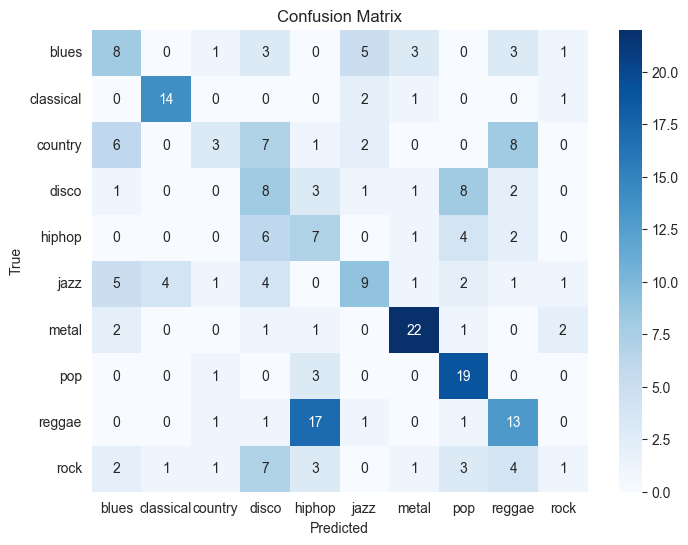

In [100]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
print(cm)  # raw matrix

# Optionally visualize as a heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=genres_list, yticklabels=genres_list,
            cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()